In [1]:
import numpy as np
import cv2
import os
import sys
import json
import math
from glob import glob
from pprint import pprint
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import albumentations as A
import lanms
from albumentations.pytorch import ToTensorV2
from imageio import imread
sys.path.append('/opt/ml/code/')
from model import EAST
from detect import detect

def draw_bbox(image, bbox, color=(0,0,255), thickness=1, thickness_sub=None, double_lined=False, write_point_numbers=False):
    """
    이미지에 하나의 Bounding Box를 그려넣는 함수
    """
    thickness_sub = thickness_sub or thickness * 3
    basis = max(image.shape[:2])
    fontsize = basis / 1500
    x_offset, y_offset = int(fontsize * 12), int(fontsize * 10)
    color_sub = (255 - color[0], 255 - color[1], 255 - color[2])

    points = [(int(np.rint(p[0])), int(np.rint(p[1]))) for p in bbox]

    for idx in range(len(points)):
        if double_lined:
            cv2.line(image, points[idx], points[(idx + 1) % len(points)], color_sub, thickness=thickness_sub)
        cv2.line(image, points[idx], points[(idx + 1) % len(points)], color, thickness= thickness)

    if write_point_numbers:
        for idx in range(len(points)):
            loc = (points[idx][0] - x_offset, points[idx][1] - y_offset)
            if double_lined:
                cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color_sub, thickness_sub, cv2.LINE_AA)
            cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color, thickness, cv2.LINE_AA)

def draw_bboxes(image, bboxes, color=(0, 0, 255), thickness=1, thickness_sub=None, double_lined=False, write_point_numbers=False):
    """
    이미지에 여러 Bounding Box들을 그려넣는 함수
    """
    for bbox in bboxes:
        draw_bbox(image, bbox, color=color,
                    thickness=thickness, thickness_sub=thickness_sub,
                    double_lined=double_lined, write_point_numbers=write_point_numbers)

def gray_mask_to_heatmap(x):
    x = cv2.cvtColor(cv2.applyColorMap(x, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
    return x

def get_superimposed_image(image, score_map, heatmap=True, w_image=None, w_map=None):
    """
    이미지에 map/mask 등을 중첩하여 그려주는 함수
    Args:
        image (ndarray) : (H, W, C) Shaped, float32 or uint8 dtype is allowed
        score_map (ndarray) : (H, W) Shaped, float32 or uint8 dtype is allowed
        heatmap (boot) : Wheather to convert 'score_map' into a heatmap.
        w_image (float)
        w_map (float)
    Blending weight (w_image and w_map) are default to (0.4, 0.6).
    """
    assert w_image is None or (w_image > 0 and w_image < 1)
    assert w_map is None or (w_map > 0 and w_map < 1)

    if image.dtype != np.uint8:
        image = (255 * np.clip(image, 0, 1)).astype(np.uint8)
    
    if score_map.dtype != np.uint8:
        score_map = (255 * np.clip(score_map, 0, 1)).astype(np.uint8)
    if heatmap:
        score_map = gray_mask_to_heatmap(score_map)
    elif score_map.ndim == 2 or score_map.shape[2] != 3:
        score_map = cv2.cvtColor(score_map, cv2.COLOR_GRAY2RGB)

    if w_image is None and w_map is None:
        w_image, w_map = 0.4, 0.6
    elif w_image is None:
        w_image = 1 - w_map
    elif w_map is None:
        w_map = 1 - w_image
    
    return cv2.addWeighted(image, w_image, score_map, w_map, 0)



/opt/ml/input/data/ICDAR17_Korean_/images/img17_107.jpg
Image: 	(1836, 2448, 3)
Bounding boxes: 	(2, 4, 2)
Labels:	(2,)


/tmp/ipykernel_11275/2109635581.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(image_fpath)


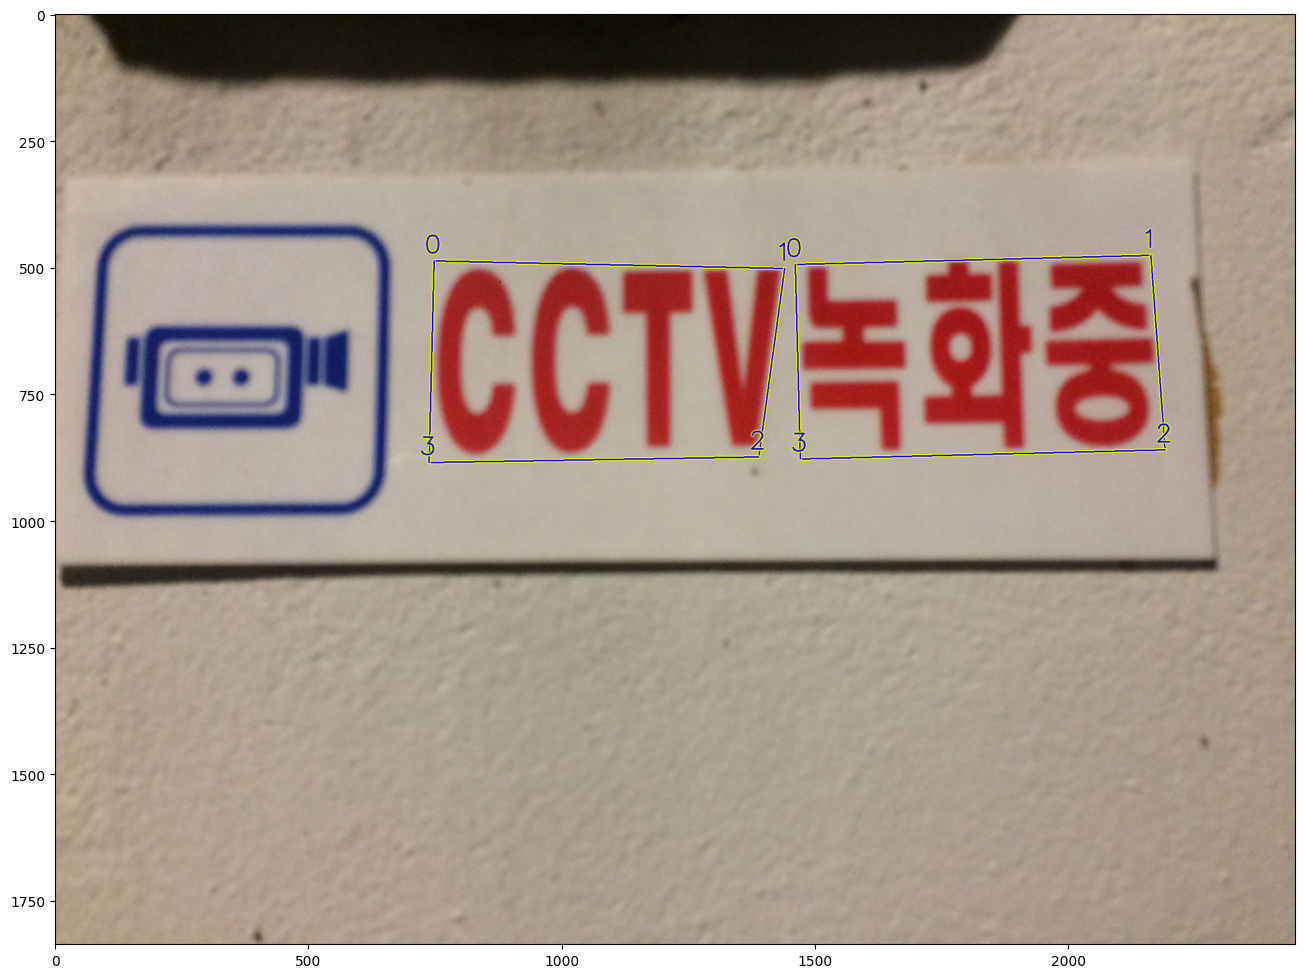

In [3]:
SAMPLE_IDX = 10
base_path = "/opt/ml/input/data/ICDAR17_Korean_/"

ufo_fpath = base_path + "ufo/train.json"
with open(ufo_fpath, 'r') as f:
    ufo_anno = json.load(f)
sample_ids = sorted(ufo_anno['images'])
sample_id = sample_ids[SAMPLE_IDX]
image_fpath = base_path + "images/" + sample_id
image = imread(image_fpath)

print(image_fpath)
print('Image: \t{}'.format(image.shape))

bboxes, labels = [], []
for word_info in ufo_anno['images'][sample_id]['words'].values():
    bboxes.append(np.array(word_info['points']))
    labels.append(int(not word_info['illegibility']))
bboxes, labels = np.array(bboxes, dtype=np.float32), np.array(labels, dtype=np.float32)
print('Bounding boxes: \t{}'.format(bboxes.shape))
print('Labels:\t{}'.format(labels.shape))

vis = image.copy()
draw_bboxes(vis, bboxes, double_lined=True, thickness=2, thickness_sub=5, write_point_numbers=True)

plt.figure(figsize=(16, 16))
plt.imshow(vis)